In [1]:
import os 
import utils 
import numpy as np 
import geopandas as gpd
from pyogrio import read_dataframe
import tkinter as tk 
from tkinter import filedialog 
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from geocube.api.core import make_geocube
import xarray as xr
import pyfftw
import scipy.fftpack
from rasterstats import zonal_stats 

## Import and rasterize shapefile

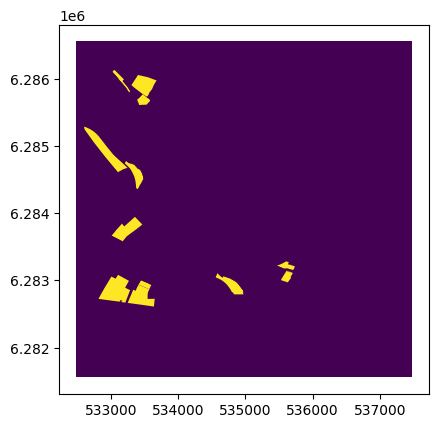

In [4]:
tk.Tk().withdraw()
shapefile_path = '/home/theo/Bureau/CDD/RPG_2015_2022/Occitanie/UPDATED_FILES_aucamville/area_1/aucamville_area1_year1'

shapefile_year_2_path = shapefile_path[:-1] + str(int(shapefile_path[-1]) + 1)   # Next year in the sequence
shapefile = read_dataframe(shapefile_path)

# Convert mustard fields to colza fields 
shapefile.loc[shapefile['CodeAgg'] == 'Mou', 'CodeAgg'] = 'Col'

downscale = 5
out_raster = utils.CustomRaster(shapefile, emission = 50, type_of_plant = 'Col', resolution = (-downscale, downscale))
out_grid = out_raster.geocube
xar_grid = out_grid.NumValue

fig = plt.figure()
ax = fig.add_subplot()
shapefile.plot(ax=ax, column = 'NumValue')
plt.show()

## Create diffusion kernel 

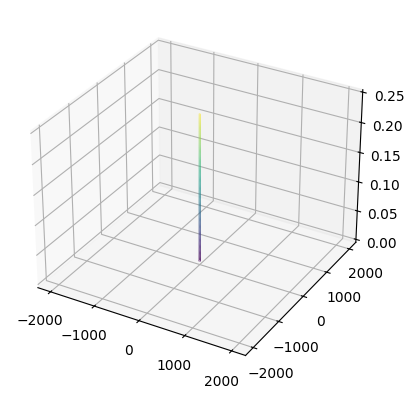

In [6]:
resized_area_length = max(out_grid.sizes['x'], out_grid.sizes['y'])

x = y = np.linspace(-2*resized_area_length, 2*resized_area_length, num = 2*resized_area_length+1) 
z = utils.dispersion_kernel(x, y, mu = 250, beta2 = 0.2, normalize_kernel=True)

scipy.fftpack = pyfftw.interfaces.scipy_fftpack  #patch scipy.signal.fftconvolve to use pyfftw interface
array = np.array(out_grid.NumValue)
convolved = scipy.signal.fftconvolve(array, z, mode = 'same')

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.contour3D(x, y, z, 200, cmap='viridis')
plt.show()

## Convolve

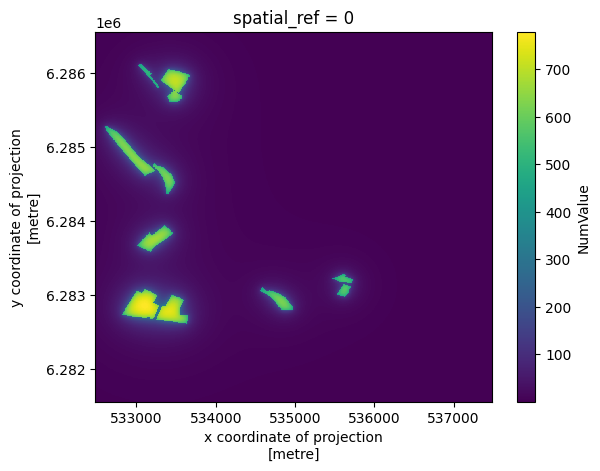

In [10]:
raster_copy = out_grid.copy()

def apply_convolution(array):
    return scipy.signal.fftconvolve(array, z, mode = 'same')

convolved_raster = raster_copy.apply(apply_convolution)
convolved_raster.NumValue.plot()

In [103]:
def place_colza_for_year2(gdf_year2, prop_random_fields, seed):
    """
    Prepares the GeoDataFrame for the next year by converting mustard fields to 
    colza (if prop_random_fields is not provided) or selecting a random 
    set of fields that will be considered colza fields for the simulation. By
    setting the random seed here, we ensure that with the same input parameters
    we will always get the same field configuration, allowing us to test 
    multiple kernels in indentical conditions. 

    Parameters:
    gdf_year2 (geopandas.GeoDataFrame): GeoDataFrame for the year n+1.
    prop_random_fields (float, optional): Proportion of random fields to be 
    converted to colza. If None, only does mustard to colza conversion.
    seed (float): The random seed to use.

    Returns:
    geopandas.GeoDataFrame: Modified GeoDataFrame for the next year with 
    updated 'CodeAgg' values to reflect colza field conversions.
    """
    res_df = gdf_year2.copy()
    if not prop_random_fields:
        res_df.loc[res_df['CodeAgg'] == 'Mou', 'CodeAgg'] = 'Col'
    else:
        mask = res_df['CodeAgg'].isin(['Ann', 'Col', 'Mou'])
        filtered_df = res_df[mask]
        
        random.seed(seed)  
        sel_indices = random.sample(
            sorted(filtered_df.index),
            k = int(len(filtered_df) * prop_random_fields)
        )
        res_df['CodeAgg'] = np.where(
            res_df.index.isin(sel_indices),
            'Col', 'not_colza'
        )
    return res_df 


In [12]:
# Prepare shapefile for next year
shapefile_year_2 = read_dataframe(shapefile_year_2_path)
shapefile_year_2.loc[shapefile_year_2['CodeAgg'] == 'Mou', 'CodeAgg'] = 'Col'  # Transform mustard into colza
shapefile_year_2.loc[shapefile_year_2['CODE_CULTU'] == 'BOR', 'CodeAgg'] = 'Per'
#shapefile_year_2 = place_colza_for_year2(shapefile_year_2, 0.01, 3)

raster_numvalue = convolved_raster.NumValue
raster_array = raster_numvalue.values 
affine_transform = raster_numvalue.rio.transform()
crs = raster_numvalue.rio.crs

stats = zonal_stats(
    shapefile_year_2[shapefile_year_2['CodeAgg'] == 'Col'], 
    raster_array,
    affine = affine_transform,
    crs = crs,
    stats = ['sum', 'mean', 'count', 'std'],
    all_touched = True
)

for i, item in enumerate(stats):
    item['mean'] /= downscale**2
    item['std'] /= downscale**2

# Check total number of intercepted spores
total_intercepted_spores = sum([dico['sum'] for dico in stats])
print(total_intercepted_spores)

280462.5027379715
